# GTO to GEO

One of the most common low-thrust many revolution transfer is to go from GTO to GEO. In this example, we make use of `pyqlaw` to construct this transfer. 

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time 

import sys
sys.path.append("../../../")    # path to pyqlaw
import pyqlaw

We begin by defining our canonical scales and initial conditions. 

In [10]:
# initial and final elements: [a,e,i,RAAN,omega,ta]
LU = 42164.0
GM_EARTH = 398600.44
VU = np.sqrt(GM_EARTH/LU)
TU = LU/VU

rp_gto = 200 + 6378
ra_gto = 35786 + 6378
sma_gto = (rp_gto + ra_gto)/(2*LU)
ecc_gto = (ra_gto - rp_gto)/(ra_gto + rp_gto)
KEP0 = [sma_gto,ecc_gto,np.deg2rad(23),0,0,0]
KEPF = [1,0,np.deg2rad(3),0,0,0]

# spacecraft parameters
MU = 1500
tmax_si = 1.0    # 1 N
isp_si  = 1500   # seconds
mdot_si = tmax_si/(isp_si*9.81)  # kg/s

# non-dimensional quantities
mass0 = 1.0
tmax = tmax_si * (1/MU)*(TU**2/(1e3*LU))
mdot = np.abs(mdot_si) *(TU/MU)

Because GEO is circular and planar, Keplerian elements are not good representations for the Lyapunov controller due to the associated singularities. We will instead use the state representation based on modified equinoctial elements, but with the semilatus rectum replaced by semi-major axis:

$$
\boldsymbol{x} = [a,f,g,h,k,L]^T
$$

This set of orbital elements is called `mee_with_a` within `pyqlaw`. 
We will convert our initial Keplerian elements to this representation.

In [4]:
oe0 = pyqlaw.kep2mee_with_a(np.array(KEP0))
oeT = pyqlaw.kep2mee_with_a(np.array(KEPF))

We can now construct the Q-law problem object, making sure that we choose the appropriate `elements_type`. We also have a choice of `integrator`, where we can either choose:

- `"rk4"`: fixed-step 4th order Runge-Kutta, or
- `"rkf45"`: 4th order Runge-Kutta with 5th order step-size correction

In addition, by setting `use_sundman = True`, we are taking steps in terms of fixed angle (i.e. fixed anomaly) rather than time. This is particularly useful to decrease computational time (by reducing number of integration steps) without compromising the accuracy too much for highly elliptical orbits, where small time-steps are required near periapsis, while large time-steps can be used near apoapsis. 

For now, we will assume Keplerian dynamics, so we do not pass any `perturbations` (we set it to `None` - which is the default anyway).

In [20]:
prob = pyqlaw.QLaw(
    integrator="rk4", 
    elements_type="mee_with_a",
    verbosity=2,
    print_frequency=1000,
    use_sundman=True,
    perturbations=None,
)

We now "set" the problem, i.e. we assign it its initial and final conditions, initial mass, spacecraft engine parameters, etc. 
One important parameter to keep in mind is `woe` - this is the weights associated to each state (i.e. orbital elements) component within the Lyapunov function. A larger weight means that the controller will put higher emphasis on correcting this particular component. 

In [21]:
# setup problem
tf_max = 365.25 * 86400 / TU       # max time, in canonical scales
t_step = np.deg2rad(15)            # integration step, in angles
woe = [3.0, 1.0, 1.0, 1.0, 1.0]
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step,
    woe = woe)
prob.pretty()

Transfer:
  a  : 5.7800e-01 -> 1.0000e+00 (weight: 3.00)
  f  : 7.3009e-01 -> 0.0000e+00 (weight: 1.00)
  g  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)
  h  : 2.0345e-01 -> 2.6186e-02 (weight: 1.00)
  k  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)


Let's now solve for the transfer.

In [22]:
# solve
prob.solve()
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  3.201e-02 | -4.2191e-01 |  7.3013e-01 |  0.0000e+00 |  1.7725e-01 |  0.0000e+00 |  1.9240e-01 |
   1000 |  1.430e+02 | -1.4024e-01 |  5.0077e-01 |  1.1967e-01 |  2.5289e-02 |  1.3114e-02 |  2.5330e+02 |
Target elements successfully reached!
Exit code : 2
Converge  : True
Final state:
  a  : 1.0008e+00 (error: 7.7849e-04)
  f  : -2.7605e-03 (error: 2.7605e-03)
  g  : 3.3578e-04 (error: 3.3578e-04)
  h  : 2.6186e-02 (error: 4.5173e-07)
  k  : 1.3171e-06 (error: 1.3171e-06)
Transfer time : 270.14929952808313
Final mass    : 0.832159741238555


We can now plot and visualize the results:

Using 2701 steps for evaluation


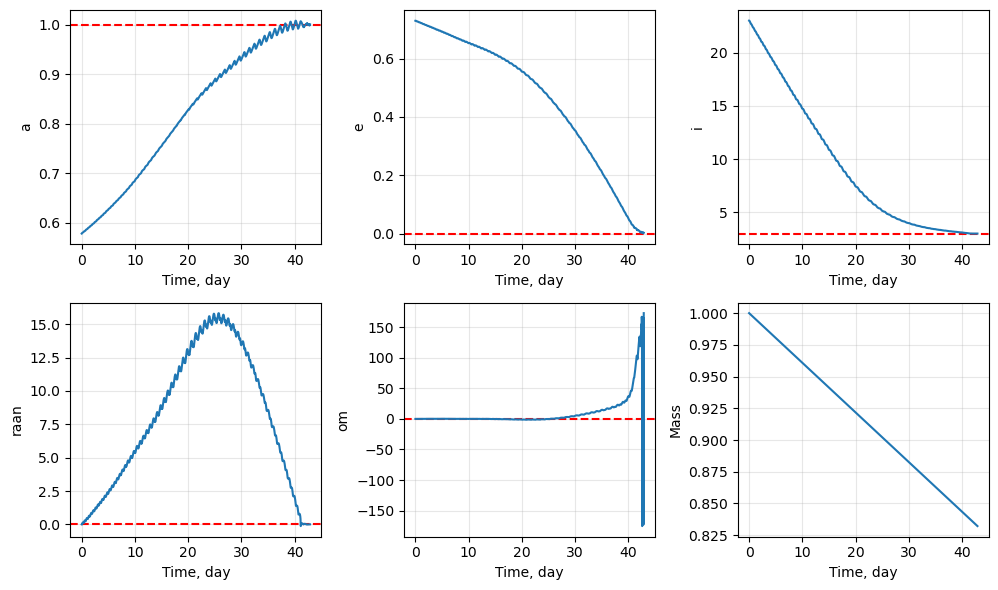

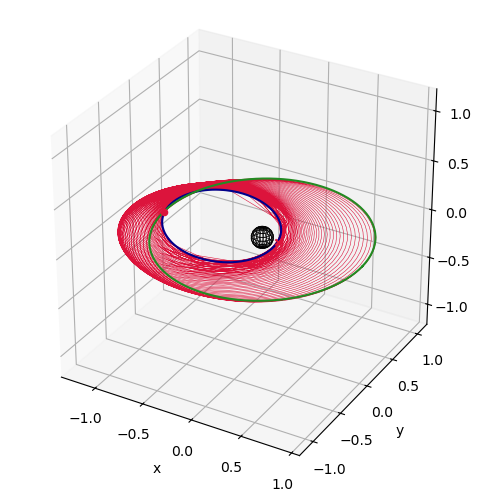

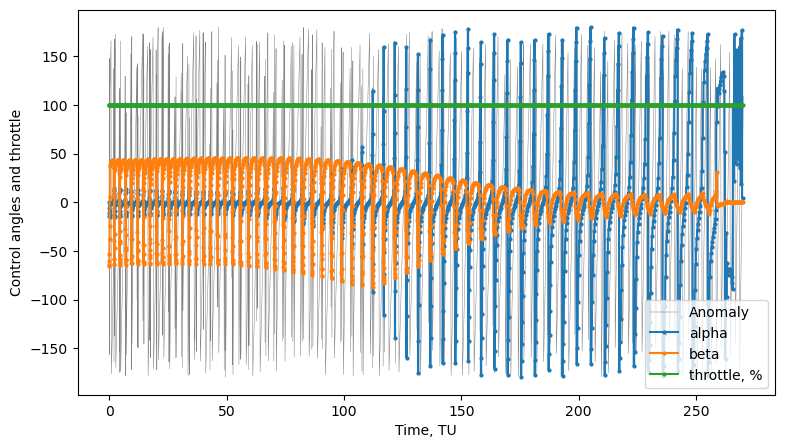

In [24]:
# plots
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
fig2, ax2 = prob.plot_trajectory_3d(sphere_radius=0.1)
fig3, ax3 = prob.plot_controls()
plt.show()